In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Padding using numpy

In [12]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values=0)
   
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


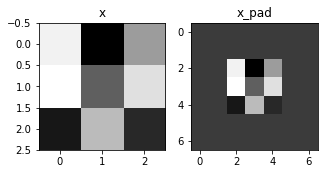

In [13]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### One step of convolution

In [14]:
def one_step_conv(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)

    return Z

In [15]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = one_step_conv(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


### CNN Forward pass

In [18]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    

    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z =  np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               
        # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]              
        # Select ith training example's padded activation
        for h in range(n_H):          
            # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):       
                # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):   
                    # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    #weights = None
                    #biases = None
                    Z[i, h, w, c] = one_step_conv(a_slice_prev, W[...,c], b[...,c])
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [19]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]
